First attempt at trying to get k-rho retreival for Raven SIMBA, limiting to only timesteps when there's no incoming SW

SECOND adding testing of surface detection

Some more info on near SIMBA thermistor locations:

at install thermistor #100 and #180(2?) were at the surface; #150 was off the upper support wood, as in it's the top of the profile into the snow; #80 and #160 were at the same height in the air

HOWEVER, the next day there was local drifting and thermistor #175 was at the surface!

at demob, thermistor #209 was just above the ice chunk, about (187-59)cm below the surface

In [1]:
import matplotlib.pyplot as plt
import datetime, time, math, cmocean, csv
import numpy as np
import netCDF4 as nc
from scipy import interpolate, stats
from matplotlib import rcParams
from astropy.convolution import convolve, convolve_fft
from scipy import interpolate
from scipy.sparse import diags
import glob
import matplotlib as mpl
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize

In [2]:
def load_netcdf(filepath, in_vars):
    """ open netcdf file, load variables (in_vars should be a list) and
        output dictionary of variables"""
    from netCDF4 import Dataset

    out_vars = {}

    open_netcdf = Dataset(filepath, mode = 'r')
    if len(in_vars)>0:
        for var in in_vars:
            out_vars[var] = open_netcdf.variables[var][:]
    else:
        for var in open_netcdf.variables.keys():
            out_vars[var] = open_netcdf.variables[var][:]

    try:
        out_vars['time_unit'] = open_netcdf.variables['time'].units
    except:
        None
    open_netcdf.close()
    #print(out_vars.keys())
    return out_vars

In [3]:
def calc_profiles(temps, secs, depths, depth_idx, time_idx, rho_0, sw_div, ktop=6, dz=0.02, bc_flx=False):

    """ salin in input variable is Salinity, S in output is storage 
    Modified for Raven to remove any k-rho relationships that are for ice/use salinity"""

    rho_1 = rho_0[depth_idx[0]]

    # poor programming! this should be an input variable!
    short_depth = depths[depth_idx[0]]

    # set up off/diagonal elements
    T_k = temps[time_idx,depth_idx[0]]
    T_k1 = temps[time_idx+1,depth_idx[0]]
    dt = secs[time_idx+1]-secs[time_idx] # just a scalar, same for whole column


    # first attempt based on Lipscomb (1998)
    a = T_k1[:-1] - T_k1[1:]
    b = T_k1[2:] - T_k1[1:-1]
    dT = T_k1 - T_k

    # from Paterson 1994
    c_t = 152.5+7.122*T_k1

    bad_top_count = 0

    for i in range(2):

        if i==0:
            rho_n = rho_1[:-1]
        elif type(K)==bool:
            rho_n = rho_1[:-1]

        else:
            rho_n = np.array([rho_from_k(k, T_k1[vidx]) \
                            for vidx, k in np.ndenumerate(np.squeeze(K))],
                            dtype=np.float32)

        # HERE is where boundary condition needs to be changed!
        if bc_flx:
            dend = bc_flx*dz
        else:
            # was 2 for sea ice, now 0.3 for snow?
            dend = 0.3*(temps[time_idx+1,depth_idx[0][-1]+1]\
                    -temps[time_idx+1,depth_idx[0][-1]])

        K, d, A, det_0_num = iterate_solution(dT, rho_n, c_t, dend, a, b, dt, sw_div)

        # work on this
        bad_snowtop = np.where((np.squeeze(K)>=.6)&(short_depth[:-1]>ktop)) #OG


        # added 6/27/22
        """neg_snowtop = np.where((np.squeeze(K)<=0.)&(short_depth[:-1]>ktop))

        if len(neg_snowtop[0])>0 and len(bad_snowtop[0])>0:

            bad_snowtop = np.concatenate((bad_snowtop[0], neg_snowtop[0]))
            bad_snowtop = [np.array(bad_snowtop)]


        elif len(neg_snowtop[0])>0:
            bad_snowtop = neg_snowtop

        if len(bad_snowtop[0])>0 and type(K)!=bool:

            intial_length = len(short_depth)

            K = np.delete(K, bad_snowtop)
            a = np.delete(a, bad_snowtop)
            b = np.delete(b, bad_snowtop)
            dT = np.delete(dT, bad_snowtop)
            rho_n = np.delete(rho_n, bad_snowtop)
            c_t = np.delete(c_t, bad_snowtop)
            d = np.delete(d, bad_snowtop)
            T_k1 = np.delete(T_k1, bad_snowtop)

            # A = np.delete(A, bad_snowtop)

            short_depth = np.delete(short_depth, bad_snowtop)

            bad_top_count = intial_length - len(short_depth)"""

        # real bad programming
        """if type(K)!=bool:

            if len(A)!=len(K) and i==4:
                print(len(A),len(K))
                for _ in range(2):
                    if type(K)==bool:
                        rho_n = rho_1[:-1]

                    else:
                        rho_n = np.array([rho_from_k(k, T_k1[vidx]) \
                                        for vidx, k in np.ndenumerate(np.squeeze(K))],
                                        dtype=np.float64)

                    dend = 2.*(temps[time_idx+1,depth_idx[0][-1]+1]\
                                -temps[time_idx+1,depth_idx[0][-1]])

                    K, d, A, det_0_num = iterate_solution(dT, rho_n, c_t, dend, a, b, dt)

                    # work on this
                    bad_snowtop = np.where((np.squeeze(K)>=.6)&(short_depth[:-1]>ktop))
                    # added 6/27/22
                    neg_snowtop = np.where((np.squeeze(K)<=0.)&(short_depth[:-1]>ktop))

                    if len(neg_snowtop[0])>0 and len(bad_snowtop[0])>0:
                        # print(bad_snowtop[0].shape, neg_snowtop[0].shape)
                        bad_snowtop = np.concatenate((bad_snowtop[0], neg_snowtop[0]))
                        bad_snowtop = [np.array(bad_snowtop)]
                        # print(bad_snowtop)
                        # print()
                    elif len(neg_snowtop[0])>0:
                        bad_snowtop = neg_snowtop


                    if len(bad_snowtop[0])>0:

                        # print('BAD K', np.shape(K))
                        intial_length = len(short_depth)

                        K = np.delete(K, bad_snowtop)
                        a = np.delete(a, bad_snowtop)
                        b = np.delete(b, bad_snowtop)
                        dT = np.delete(dT, bad_snowtop)
                        rho_n = np.delete(rho_n, bad_snowtop)
                        c_t = np.delete(c_t, bad_snowtop)
                        d = np.delete(d, bad_snowtop)
                        T_k1 = np.delete(T_k1, bad_snowtop)

                        # A = np.delete(A, bad_snowtop)

                        short_depth = np.delete(short_depth, bad_snowtop)

                        bad_top_count = intial_length - len(short_depth)
                        K, d, A, det_0_num = iterate_solution(dT, rho_n, c_t, dend, a, b, dt)"""

        S = d/dz # this negates dz d is multiplied by to solve for k

    # save conduction and its divergence
    # print(np.shape(np.squeeze(K)[1:]), np.shape(T_k1[2:]), np.shape(T_k1[1:-1]))
    # print(A.shape, K.shape, a.shape, b.shape, T_k1.shape, rho_n.shape)
    # this is conserved
    if type(K)==bool:
        Fc_div = False
        Fc = False
    else:
        # print(np.shape(np.squeeze(K)), np.shape(T_k1))
        # print(np.shape(np.squeeze(K)[1:]), np.shape(np.squeeze(K)[0:-1]), np.shape(T_k1[2:]), np.shape(T_k1[:-2]))
        # Fc_div =  np.squeeze(K)[:-1]*(T_k1[2:]-T_k1[1:-1]) - (np.squeeze(K)[1:]*(T_k1[1:-1]-T_k1[:-2]))
        # Fc_div /= dz**2
        Fc_div = A.dot(K)/dz

        Fc = -np.squeeze(K)*a/dz
        # alt_div = np.squeeze(K)/dz
        # print(Fc)

    return K, rho_n, S, Fc_div, Fc, bad_top_count, det_0_num

In [4]:
def iterate_solution(dT_i, rho_i, c_i, d_last, a_i, b_i, dt_i, sw_div_i, dz_i=0.02):

    # separating the calculation of d in a separate function might make it more readable

    d = dT_i[:-1]*c_i[:-1]*rho_i*dz_i**2/dt_i # Lipscomb

    # with solar, added 4/17/25
    d_S = dT_i[:-1]*c_i[:-1]*rho_i*dz_i**2/dt_i - sw_div_i[:-1]*dz_i# Lipscomb
    
    # need some sort of boundary condition
    d_S[-1] -= d_last

    offset = [0,1]
    A = diags([a_i,b_i],offset).toarray()

    # turn into matrix with correct orientation
    d_S = np.array([d_S], dtype=np.float64).T

    # if np.linalg.det(A)!=0:
    #     K_i = np.linalg.inv(A).dot(d)
    # else:
    #     K_i = np.linalg.pinv(A).dot(d)
    #
    #     # K_i = False
    K_i = np.linalg.pinv(A).dot(d_S)


    if np.linalg.det(A)==0:
        det_0 = 1
    else:
        det_0 = 0


    return K_i, d, A, det_0

In [5]:
def rho_from_k(k, T):

    rhos, ks = calc_k_approx(T)
    #print('in rho_from_k ks, rhos, k shapes:', np.shape(ks), np.shape(rhos), np.shape(k))

    rhos = np.squeeze(rhos)
    ks = np.squeeze(ks)
    # print(ks, k)

    f = interpolate.interp1d(ks, rhos)

    if k>ks.max():
        k = ks.max()
    elif k<ks.min():
        k = ks.min()

    rho_out = f(k)

    return rho_out

In [6]:
def calc_k_approx(T, rho_vals=np.linspace(50,1000,96)):

    """ calculate k values based on eq5 from calonne 2019
        T is in Kelvin"""

    rhos = []
    ks = []

    # constants for calculation
    a = 0.02 # m3/kg
    k_ref_i = 2.107 # W/m/K
    k_ref_a = 0.024 # W/m/K

    # # just use simple values for now, will want them to be functions of T later
    # # current values for T=-3C
    k_i = 9.828*np.exp(-5.7*10.**(-3)*T)
    k_a = 0.024 # get the rest of the linear approx of T

    for rho in rho_vals:

        theta = 1./(1.+np.exp(-2.*a*(rho-450.)))
        k_ref_firn = 2.107 + 0.003618*(rho-917.)
        k_ref_snow = 0.024 - (1.23*10**(-4))*rho + (2.5*10**(-6))*(rho**2)

        x_f = (1. - theta)*(k_i*k_a/(k_ref_i*k_ref_a))*k_ref_snow \
                + theta*(k_i/k_ref_i)*k_ref_firn

        # print(x_f)
        ks.append(np.float32(x_f))#[0])
        rhos.append(np.float32(rho))

    return rhos, ks

In [7]:
def nearest(items, pivot):
    return min(items, key=lambda x: abs(x - pivot))

In [8]:
## try opening all SIMBA files
# turn into function later?
simba_filepath = '/psd3data/arctic/raven/simba/level1/'

lev1_files = glob.glob(simba_filepath+'*.nc')
lev1_files.sort()

## get rid of march files, will also probably want to get rid of first few days of actual data after install as well?
lev1_files = lev1_files[5:]

In [9]:
varnames = ['temperature','height','time']

season_data = {}

for fname in lev1_files[:]:
    fdic = load_netcdf(fname, varnames)

    fstart_time = datetime.datetime.strptime(fdic['time_unit'][-19:], '%Y-%m-%d %H:%M:%S')
    fdic['dates'] = np.asarray([fstart_time+datetime.timedelta(minutes=int(m)) for m in fdic['time']])

    for var in ['temperature','dates']:
        if var not in season_data:
            season_data[var] = fdic[var]
        else:
            season_data[var] = np.ma.concatenate( (season_data[var], fdic[var]), axis=0 )

    ## only want one height:
    if 'height' not in season_data:
        season_data['height'] = fdic['height']
    print(season_data['dates'].shape, season_data['height'].shape, season_data['temperature'].shape)

(96,) (241,) (96, 241)
(192,) (241,) (192, 241)
(288,) (241,) (288, 241)
(384,) (241,) (384, 241)
(480,) (241,) (480, 241)
(576,) (241,) (576, 241)
(672,) (241,) (672, 241)
(768,) (241,) (768, 241)
(864,) (241,) (864, 241)
(960,) (241,) (960, 241)
(1056,) (241,) (1056, 241)
(1152,) (241,) (1152, 241)
(1248,) (241,) (1248, 241)
(1344,) (241,) (1344, 241)
(1440,) (241,) (1440, 241)
(1536,) (241,) (1536, 241)
(1632,) (241,) (1632, 241)
(1728,) (241,) (1728, 241)
(1824,) (241,) (1824, 241)
(1920,) (241,) (1920, 241)
(2016,) (241,) (2016, 241)
(2112,) (241,) (2112, 241)
(2208,) (241,) (2208, 241)
(2304,) (241,) (2304, 241)
(2400,) (241,) (2400, 241)
(2496,) (241,) (2496, 241)
(2592,) (241,) (2592, 241)
(2688,) (241,) (2688, 241)
(2784,) (241,) (2784, 241)
(2880,) (241,) (2880, 241)
(2976,) (241,) (2976, 241)
(3072,) (241,) (3072, 241)
(3168,) (241,) (3168, 241)
(3264,) (241,) (3264, 241)
(3360,) (241,) (3360, 241)
(3456,) (241,) (3456, 241)
(3552,) (241,) (3552, 241)
(3648,) (241,) (3648, 2

In [10]:
## also get flux files
asfs_filepath = '/psd3data/arctic/raven/asfs/level1/'
asfs_lev1_files = glob.glob(asfs_filepath+'slow*.nc')
asfs_lev1_files.sort()

asfs_lev1_files = asfs_lev1_files[12:]

varnames = ['sr30_swu_Irr_Avg','sr30_swu_IrrC_Avg','sr30_swd_Irr_Avg','sr30_swd_IrrC_Avg','skin_temp_surface',
            'sr50_dist_Avg','fp_A_Wm2_Avg', 'fp_B_Wm2_Avg', 'fp_C_Wm2_Avg','base_time','time']

asfs_data = {}

for fname in asfs_lev1_files[:]:
    print(fname)
    fdic = load_netcdf(fname, varnames)
    # 
    # print(fdic['base_time'])
    # print()
    # print(fdic['time'])
    # print(fdic['time_unit'])
    fstart_time = datetime.datetime.strptime(fdic['time_unit'], 'seconds since %Y-%m-%dT%H:%M:%S.000000')
    fdic['dates'] = np.asarray([fstart_time+datetime.timedelta(seconds=int(m)) for m in fdic['time']])

    for var in varnames[:-2]+['dates']:
        if var not in asfs_data:
            asfs_data[var] = fdic[var]
        else:
            asfs_data[var] = np.ma.concatenate( (asfs_data[var], fdic[var]), axis=0 )


/psd3data/arctic/raven/asfs/level1/slow.level1.melt-sleighsfs.20240513.000000.nc
/psd3data/arctic/raven/asfs/level1/slow.level1.melt-sleighsfs.20240514.000000.nc
/psd3data/arctic/raven/asfs/level1/slow.level1.melt-sleighsfs.20240515.000000.nc
/psd3data/arctic/raven/asfs/level1/slow.level1.melt-sleighsfs.20240516.000000.nc
/psd3data/arctic/raven/asfs/level1/slow.level1.melt-sleighsfs.20240517.000000.nc
/psd3data/arctic/raven/asfs/level1/slow.level1.melt-sleighsfs.20240518.000000.nc
/psd3data/arctic/raven/asfs/level1/slow.level1.melt-sleighsfs.20240519.000000.nc
/psd3data/arctic/raven/asfs/level1/slow.level1.melt-sleighsfs.20240520.000000.nc
/psd3data/arctic/raven/asfs/level1/slow.level1.melt-sleighsfs.20240521.000000.nc
/psd3data/arctic/raven/asfs/level1/slow.level1.melt-sleighsfs.20240522.000000.nc
/psd3data/arctic/raven/asfs/level1/slow.level1.melt-sleighsfs.20240523.000000.nc
/psd3data/arctic/raven/asfs/level1/slow.level1.melt-sleighsfs.20240524.000000.nc
/psd3data/arctic/raven/asfs/

Start with one time step that has no SWD, near beginning of timeseries before any accumlation or melt

5-15/5-16 night?

In [11]:
st_date = datetime.datetime(2024,5,21,2)
en_date = datetime.datetime(2024,5,21,4)

In [12]:
date_idx_asfs = np.where((asfs_data[var]>st_date)&(asfs_data[var]<en_date) )[0]

In [13]:
print(asfs_data['sr30_swd_IrrC_Avg'][date_idx_asfs])

[0.8116666 0.8999999 0.8599999 0.9833333 1.181667 1.281667 1.348333
 1.381667 1.351667 1.236667 1.021667 0.7999999 0.7933333 0.885 0.8916666
 0.8133333 0.7833333 0.795 0.84 0.94 1.048333 1.116667 1.116667 1.026667
 0.97 0.66 0.4433333 0.5933333 0.6366666 0.575 0.5133333 0.5233333
 0.6849999 0.835 0.8466666 0.8433333 0.645 0.27 28633110.0 42949670.0
 42949670.0 42949670.0 0.2683333 0.6966666 0.95 1.103333 1.22 1.315
 1.416667 1.418333 1.35 1.245 0.9949999 0.9483333 1.185 1.31 1.288333
 1.255 1.236667 1.18 1.156667 1.116667 1.016667 0.9766666 0.9133334
 0.8683334 0.77 0.7683333 0.6466666 0.4666667 0.3966666 0.4466666 0.365
 0.3866666 0.3516666 0.5533334 0.7266666 1.036667 1.47 1.641667 1.576667
 1.525 1.263333 0.92 0.5266666 0.1183333 0.37 0.7516666 0.96 1.046667
 0.9099999 1.008333 0.9266666 0.725 0.6566666 0.8883334 1.038333 1.146667
 1.225 1.395 1.488333 1.375 1.346667 1.413333 1.476667 1.496667 1.445
 1.376667 1.381667 1.421667 1.428333 1.351667 1.195 1.223333 1.285
 1.396667 1.44666

In [14]:
date_idx_imb = np.where((season_data['dates']>st_date)&(season_data['dates']<en_date) )[0]

Variables used in MOSAiC data:

    temp_kelv = simb_dic['temperature']+273.15
    simb_depth = simb_dic['depth']
    simb_depth_m = simb_depth/100.
    simb_time = simb_dic['dates']
    simb_secs = np.array([(t-datetime.datetime(1970,1,1)).total_seconds() for \
                            _,t in np.ndenumerate(simb_time)])

In [11]:
temp_kelv = season_data['temperature']+273.15
imb_depth = season_data['height']
imb_depth_m = imb_depth/100.

# how best to limit depths?
sfc_height = -350/100. # from thermistor locations at install
bottom_height = -(360+75)/100. # currently lowest level is now bottom flx plate; was set to -470 right now removing bottom thermistor that looks like it might be the air temp?

imb_secs = np.array([(t-datetime.datetime(1970,1,1)).total_seconds() for _,t in np.ndenumerate(season_data['dates'])])

In [16]:
print(sfc_height, bottom_height)

-3.5 -4.35


In [12]:
## for plotting and comparing
dTdt = (season_data['temperature'][1:,:] - season_data['temperature'][:-1,:])#/(15.*60) # timesteps are 15 minutes
dTdz = (season_data['temperature'][:,1:] - season_data['temperature'][:,:-1])#/0.02 # vertical resolution is 2 cm

In [13]:
# read in manual heights, assess and adjust!
man_heights = np.genfromtxt('/home/asledd/ICECAPS/SLEIGH_SIMBA_manual_sfc_id.csv', delimiter=',', skip_header=3)

## say what's what
sfc_heights = {'dates':np.asarray([ datetime.datetime(int(value[0]),int(value[1]),int(value[2])) for value in man_heights]),
               'surface':np.asarray([ value[3] for value in man_heights])}

(41, 1) (42,) (9504, 1, 42)
(41, 1) (42,) (9504, 1, 42)
(41, 1) (42,) (9504, 1, 42)
(41, 1) (42,) (9504, 1, 42)
(41, 1) (42,) (9504, 1, 42)
(41, 1) (42,) (9504, 1, 42)


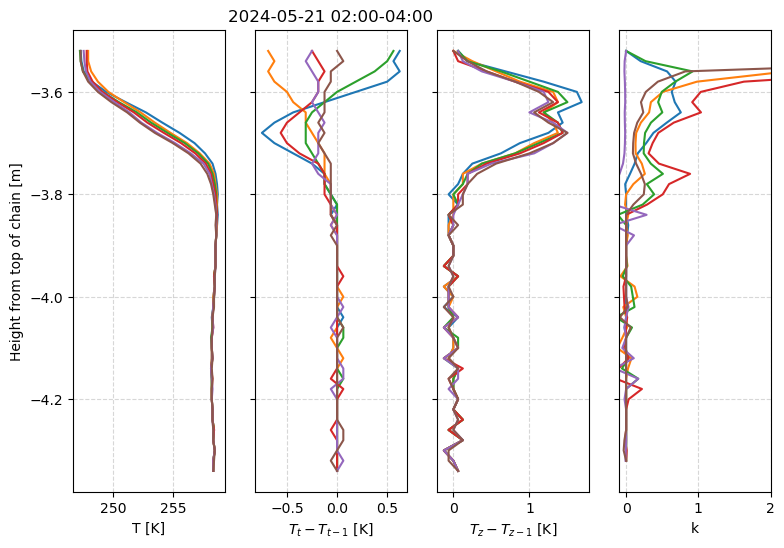

In [19]:


## rename these!
k_2d = []
rho_2d = []
S_2d = []
Fc_2d = []
Fc_div_2d = []

plt_times = []
plt_secs = []
plt_bad_timesteps = []

fig, axs = plt.subplots(1,4, figsize=(9,6), sharey=True)
axs[0].set_ylabel('Height from top of chain [m]')
for _, t_idx in np.ndenumerate(date_idx_imb[1:]):
    
        all_depths_K = []
        all_depths_rho = []
        all_depths_S = []
        all_depths_Fc = []
        all_depths_Fc_div = []

        depth_idx = np.where((imb_depth_m<sfc_height)&(imb_depth_m>=bottom_height))
        rho = np.full(imb_depth_m.shape, 300.)
        
        K, rho_n, S, Fc_div, Fc, bad_top, det_0_num = calc_profiles(temp_kelv[:,:],
                                    imb_secs[:], imb_depth_m, depth_idx, t_idx, rho, bc_flx=.5) # bc_flx = 'boundary condition flux'

        axs[0].plot(np.squeeze(temp_kelv[t_idx, depth_idx]), imb_depth_m[depth_idx], label=t_idx)#'t=0')
    
        axs[1].plot(np.squeeze(dTdt[t_idx, depth_idx]), imb_depth_m[depth_idx])
        axs[2].plot(np.squeeze(dTdz[t_idx, depth_idx]), imb_depth_m[depth_idx])
        axs[3].plot(K, imb_depth_m[depth_idx][:-1])

    
        print(K.shape, imb_depth_m[depth_idx].shape, temp_kelv[:,depth_idx].shape)
        if type(K)!=bool:
            # print(sd, len(K), len(depth_idx[0]))
            all_depths_K.append(np.squeeze(K))
            all_depths_rho.append(rho_n)
            all_depths_S.append(np.squeeze(S)[:-1])
            all_depths_Fc.append(Fc)
            all_depths_Fc_div.append(Fc_div)


            len_ld = len(depth_idx[0])

# axs[0].plot(np.squeeze(temp_kelv[date_idx_imb[0], depth_idx]), imb_depth_m[depth_idx], label='t=-1')
# axs[0].plot(np.squeeze(temp_kelv[date_idx_imb[2], depth_idx]), imb_depth_m[depth_idx], label='t=+1')
# axs[0].legend(loc='best')
#for ax, label in zip(axs.ravel(), ['Temp [K]', 'dT/dt', 'dT/dz','k']):
for ax, label in zip(axs.ravel(), ['T [K]', '$T_t-T_{t-1}$ [K]', '$T_z-T_{z-1}$ [K]','k']):
    ax.set_xlabel(label)
    ax.grid(alpha=.5, ls='--')

axs[-1].set_xlim(-.1,2)
axs[1].set_title(st_date.strftime('%Y-%m-%d %H:%M')+'-'+en_date.strftime('%H:%M'))
#plt.savefig('raven_T_Tt_Tz_deltas_'+st_date.strftime('%Y-%m-%d:%H:%M')+'-'+en_date.strftime('%H:%M')+'.png', dpi=200)
plt.show()

From the logbook, "The plates were installed at -25cm (plate A), -50 cm (B), and -75 cm ( C)...The plates were installed, backfilled, and stabilized by about 21:30 UTC" on 5/15/24 and then later it says that plates A and C are switched (5/18/24)

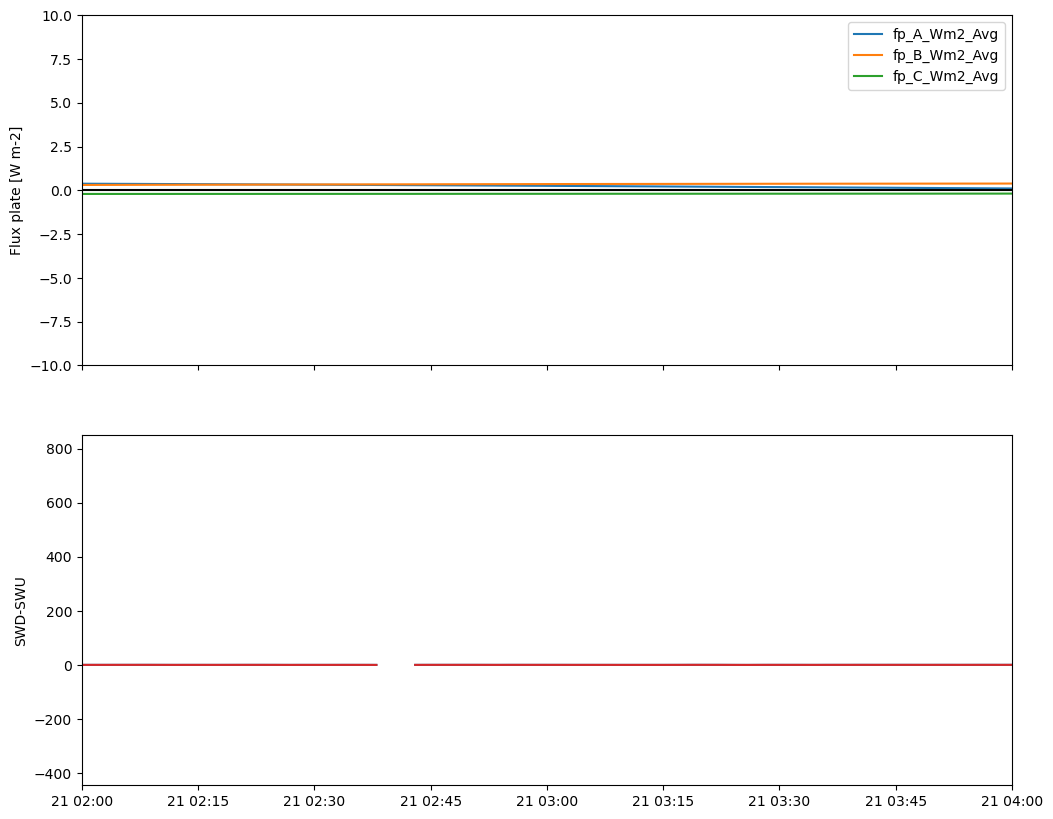

In [20]:

short_idx = np.where((asfs_data['dates']>datetime.datetime(2024,5,15))&(asfs_data['dates']<datetime.datetime(2024,6,21)))[0]
fig, axs = plt.subplots(2, figsize=(12,10), sharex=True)
# 'sr30_swd_Irr_Avg','sr30_swu_IrrC_Avg',



swn = np.ma.masked_outside(asfs_data['sr30_swd_IrrC_Avg'][short_idx], -1000,1000) - np.ma.masked_outside(asfs_data['sr30_swu_Irr_Avg'][short_idx], -1000,1000)
axs[1].plot(asfs_data['dates'][short_idx], swn)

axs[1].plot(asfs_data['dates'][short_idx], np.ma.masked_greater(swn,1), c='tab:red')

axs[1].set_ylabel('SWD-SWU')




#fig, ax = plt.subplots(1, figsize=(12,4))
for fp in ['fp_A_Wm2_Avg', 'fp_B_Wm2_Avg', 'fp_C_Wm2_Avg']:
    axs[0].plot(asfs_data['dates'], asfs_data[fp], label=fp)
axs[0].set_ylim(-10,10)
axs[0].legend(loc='best')
axs[0].axhline(y=0, c='k')
# axs[0].set_xlim(datetime.datetime(2024,5,15),datetime.datetime(2024,6,1))
axs[0].set_xlim(st_date, en_date)
axs[0].set_ylabel('Flux plate [W m-2]')
plt.show()

In [21]:
cbar_ticks = [season_data['dates'][date_idx_imb[idx]] for idx in [0, int(len(date_idx_imb)/2), len(date_idx_imb)-1]]

print(cbar_ticks)

[datetime.datetime(2024, 5, 21, 2, 15), datetime.datetime(2024, 5, 21, 3, 0), datetime.datetime(2024, 5, 21, 3, 45)]


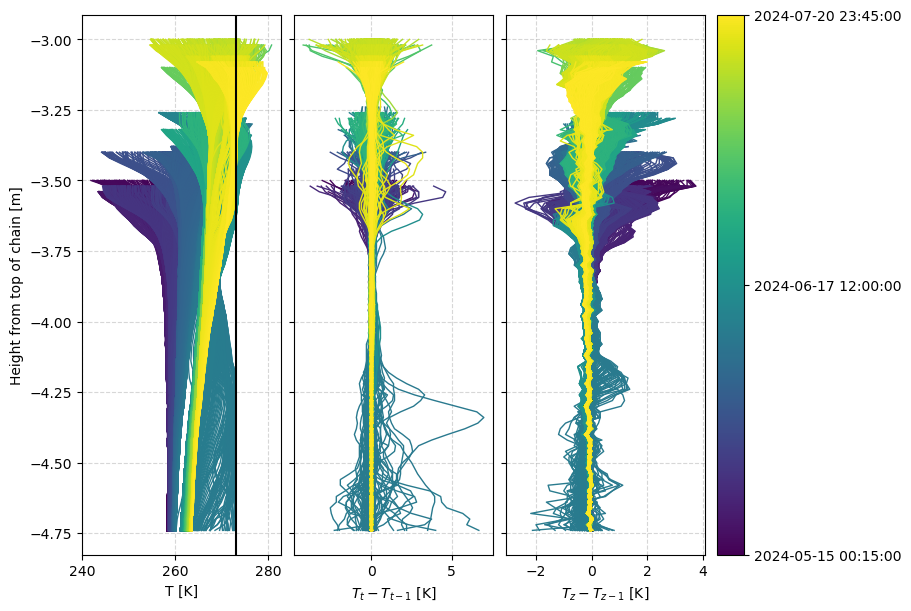

In [22]:


st_date = datetime.datetime(2024,5,15)
en_date = datetime.datetime(2024,7,21)
date_idx_imb = np.where((season_data['dates']>st_date)&(season_data['dates']<en_date) )[0]

cbar_ticks = [season_data['dates'][date_idx_imb[idx]] for idx in [0, int(len(date_idx_imb)/2), len(date_idx_imb)-1]]

imb_sfc_temp = []
imb_nr_sfc_temp = []
imb_abv_sfc_temp = []
imb_sfc_dates = []
imb_2abv_sfc_temp = []

fig, axs = plt.subplots(1,3, figsize=(9,6), sharey=True, constrained_layout=True)
axs[0].set_ylabel('Height from top of chain [m]')
for i, t_idx in np.ndenumerate(date_idx_imb[:]):


    close_height_date = nearest(sfc_heights['dates'], season_data['dates'][t_idx])
    sfc_height = sfc_heights['surface'][np.where(sfc_heights['dates']==close_height_date)[0]]
    # print(sfc_height,bottom_height)
    depth_idx = np.where((imb_depth_m<=sfc_height/100.)&(imb_depth_m>=-4.75)) # cut off bottom thermistor that's the air temp
    # depth_idx = np.where(imb_depth_m<=sfc_height/100.)
    # depth_idx_dTdz = np.where(imb_depth_m[:-1]<=sfc_height/100.)

    # print(depth_idx)
    rho = np.full(imb_depth_m.shape, 300.)
    
    # K, rho_n, S, Fc_div, Fc, bad_top, det_0_num = calc_profiles(temp_kelv[:,:],
    #                             imb_secs[:], imb_depth_m, depth_idx, t_idx, rho, bc_flx=.5) # bc_flx = 'boundary condition flux'

    col = plt.cm.viridis(i[0]/len(date_idx_imb))
    axs[0].plot(np.squeeze(temp_kelv[t_idx, depth_idx]), imb_depth_m[depth_idx], label=t_idx, c=col, lw=1)

    axs[1].plot(np.squeeze(dTdt[t_idx, depth_idx]), imb_depth_m[depth_idx], c=col, lw=1)
    axs[2].plot(np.squeeze(dTdz[t_idx, depth_idx]), imb_depth_m[depth_idx], c=col, lw=1)
    # axs[3].plot(K, imb_depth_m[depth_idx][:-1])

    ## save for analysis
    try:
        imb_sfc_temp.append(temp_kelv[t_idx, depth_idx[0][0]])
        imb_nr_sfc_temp.append(temp_kelv[t_idx, depth_idx[0][1]])
        imb_sfc_dates.append(season_data['dates'][t_idx])
        imb_abv_sfc_temp.append(temp_kelv[t_idx, depth_idx[0][0]-1])
        imb_2abv_sfc_temp.append(temp_kelv[t_idx, depth_idx[0][0]-2])

    except:
        imb_sfc_temp.append(np.nan)
        imb_nr_sfc_temp.append(np.nan)
        imb_sfc_dates.append(season_data['dates'][t_idx])
        imb_abv_sfc_temp.append(np.nan)
        imb_2abv_sfc_temp.append(np.nan)

axs[0].axvline(x=273.1, c='k')
# axs[0].plot(np.squeeze(temp_kelv[date_idx_imb[0], depth_idx]), imb_depth_m[depth_idx], label='t=-1')
# axs[0].plot(np.squeeze(temp_kelv[date_idx_imb[2], depth_idx]), imb_depth_m[depth_idx], label='t=+1')
# axs[0].legend(loc='best')
#for ax, label in zip(axs.ravel(), ['Temp [K]', 'dT/dt', 'dT/dz','k']):
for ax, label in zip(axs.ravel(), ['T [K]', '$T_t-T_{t-1}$ [K]', '$T_z-T_{z-1}$ [K]']):
    ax.set_xlabel(label)
    ax.grid(alpha=.5, ls='--')

cmappable = ScalarMappable(norm=Normalize(0,2), cmap=plt.cm.viridis)

#colorbar from https://stackoverflow.com/questions/65618997/python-matplotlib-custom-colorbar-for-plotted-lines-with-manually-assigned-color
cbar = plt.colorbar(cmappable, ticks=np.arange(0, 3))# label='Change in user population')
cbar.ax.set_yticklabels(cbar_ticks)

#axs[-1].set_xlim(-.1,2)
# axs[1].set_title(st_date.strftime('%Y-%m-%d %H:%M')+'-'+en_date.strftime('%H:%M'))
# plt.savefig('raven_T_Tt_Tz_deltas_'+st_date.strftime('%Y-%m-%d')+'-'+en_date.strftime('%Y-%m-%d')+'_man-sfc.png', dpi=200)
plt.show()

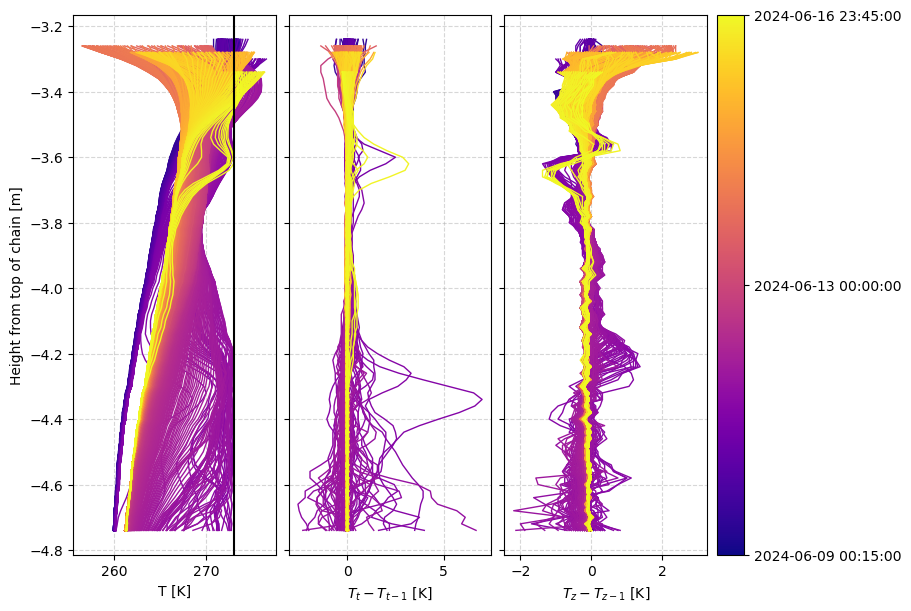

In [19]:


st_date = datetime.datetime(2024,6,9)
en_date = datetime.datetime(2024,6,17)
date_idx_imb = np.where((season_data['dates']>st_date)&(season_data['dates']<en_date) )[0]

cbar_ticks = [season_data['dates'][date_idx_imb[idx]] for idx in [0, int(len(date_idx_imb)/2), len(date_idx_imb)-1]]

imb_sfc_temp = []
imb_nr_sfc_temp = []
imb_abv_sfc_temp = []
imb_sfc_dates = []
imb_2abv_sfc_temp = []

fig, axs = plt.subplots(1,3, figsize=(9,6), sharey=True, constrained_layout=True)
axs[0].set_ylabel('Height from top of chain [m]')
for i, t_idx in np.ndenumerate(date_idx_imb[:]):


    close_height_date = nearest(sfc_heights['dates'], season_data['dates'][t_idx])
    sfc_height = sfc_heights['surface'][np.where(sfc_heights['dates']==close_height_date)[0]]
    # print(sfc_height,bottom_height)
    depth_idx = np.where((imb_depth_m<=sfc_height/100.)&(imb_depth_m>=-4.75)) # cut off bottom thermistor that's the air temp
    # depth_idx = np.where(imb_depth_m<=sfc_height/100.)
    # depth_idx_dTdz = np.where(imb_depth_m[:-1]<=sfc_height/100.)

    # print(depth_idx)
    rho = np.full(imb_depth_m.shape, 300.)
    
    # K, rho_n, S, Fc_div, Fc, bad_top, det_0_num = calc_profiles(temp_kelv[:,:],
    #                             imb_secs[:], imb_depth_m, depth_idx, t_idx, rho, bc_flx=.5) # bc_flx = 'boundary condition flux'

    col = plt.cm.plasma(i[0]/len(date_idx_imb))
    axs[0].plot(np.squeeze(temp_kelv[t_idx, depth_idx]), imb_depth_m[depth_idx], label=t_idx, c=col, lw=1)

    axs[1].plot(np.squeeze(dTdt[t_idx, depth_idx]), imb_depth_m[depth_idx], c=col, lw=1)
    axs[2].plot(np.squeeze(dTdz[t_idx, depth_idx]), imb_depth_m[depth_idx], c=col, lw=1)
    # axs[3].plot(K, imb_depth_m[depth_idx][:-1])

    ## save for analysis
    try:
        imb_sfc_temp.append(temp_kelv[t_idx, depth_idx[0][0]])
        imb_nr_sfc_temp.append(temp_kelv[t_idx, depth_idx[0][1]])
        imb_sfc_dates.append(season_data['dates'][t_idx])
        imb_abv_sfc_temp.append(temp_kelv[t_idx, depth_idx[0][0]-1])
        imb_2abv_sfc_temp.append(temp_kelv[t_idx, depth_idx[0][0]-2])

    except:
        imb_sfc_temp.append(np.nan)
        imb_nr_sfc_temp.append(np.nan)
        imb_sfc_dates.append(season_data['dates'][t_idx])
        imb_abv_sfc_temp.append(np.nan)
        imb_2abv_sfc_temp.append(np.nan)

axs[0].axvline(x=273.1, c='k')
# axs[0].plot(np.squeeze(temp_kelv[date_idx_imb[0], depth_idx]), imb_depth_m[depth_idx], label='t=-1')
# axs[0].plot(np.squeeze(temp_kelv[date_idx_imb[2], depth_idx]), imb_depth_m[depth_idx], label='t=+1')
# axs[0].legend(loc='best')
#for ax, label in zip(axs.ravel(), ['Temp [K]', 'dT/dt', 'dT/dz','k']):
for ax, label in zip(axs.ravel(), ['T [K]', '$T_t-T_{t-1}$ [K]', '$T_z-T_{z-1}$ [K]']):
    ax.set_xlabel(label)
    ax.grid(alpha=.5, ls='--')

cmappable = ScalarMappable(norm=Normalize(0,2), cmap=plt.cm.plasma)

#colorbar from https://stackoverflow.com/questions/65618997/python-matplotlib-custom-colorbar-for-plotted-lines-with-manually-assigned-color
cbar = plt.colorbar(cmappable, ticks=np.arange(0, 3))# label='Change in user population')
cbar.ax.set_yticklabels(cbar_ticks)

#axs[-1].set_xlim(-.1,2)
# axs[1].set_title(st_date.strftime('%Y-%m-%d %H:%M')+'-'+en_date.strftime('%H:%M'))
plt.savefig('raven_T_Tt_Tz_deltas_'+st_date.strftime('%Y-%m-%d')+'-'+en_date.strftime('%Y-%m-%d')+'_man-sfc.png', dpi=200)
plt.show()

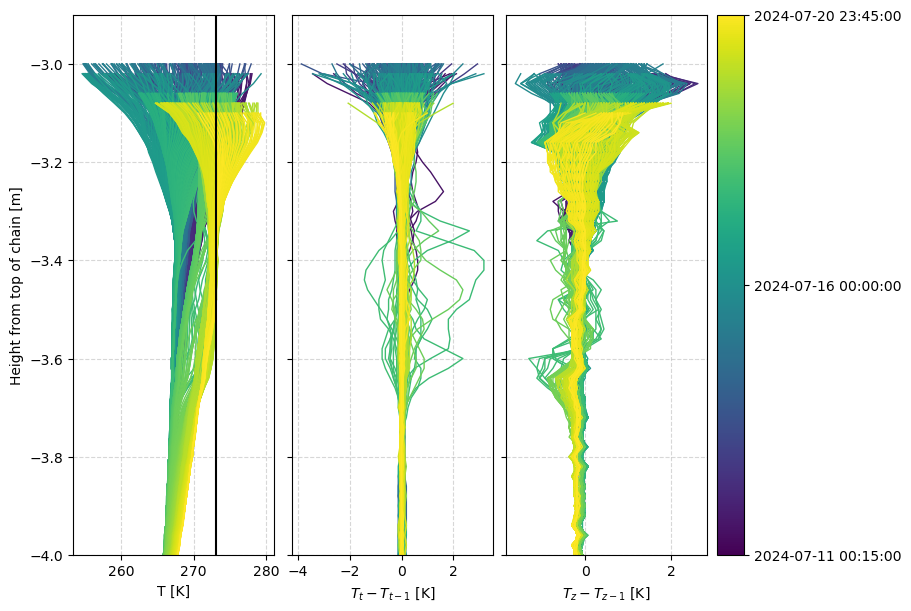

In [30]:


st_date = datetime.datetime(2024,7,11)
en_date = datetime.datetime(2024,7,21)
date_idx_imb = np.where((season_data['dates']>st_date)&(season_data['dates']<en_date) )[0]

cbar_ticks = [season_data['dates'][date_idx_imb[idx]] for idx in [0, int(len(date_idx_imb)/2), len(date_idx_imb)-1]]
    
fig, axs = plt.subplots(1,3, figsize=(9,6), sharey=True, constrained_layout=True)
axs[0].set_ylabel('Height from top of chain [m]')
for i, t_idx in np.ndenumerate(date_idx_imb[:]):

        close_height_date = nearest(sfc_heights['dates'], season_data['dates'][t_idx])
        sfc_height = sfc_heights['surface'][np.where(sfc_heights['dates']==close_height_date)[0]]
        # print(sfc_height,bottom_height)
        depth_idx = np.where((imb_depth_m<=sfc_height/100.)&(imb_depth_m>=-4.75)) # cut off bottom thermistor that's the air temp
        # depth_idx = np.where(imb_depth_m<=sfc_height/100.)
        # depth_idx_dTdz = np.where(imb_depth_m[:-1]<=sfc_height/100.)

        # print(depth_idx)
        rho = np.full(imb_depth_m.shape, 300.)
        
        # K, rho_n, S, Fc_div, Fc, bad_top, det_0_num = calc_profiles(temp_kelv[:,:],
        #                             imb_secs[:], imb_depth_m, depth_idx, t_idx, rho, bc_flx=.5) # bc_flx = 'boundary condition flux'

        col = plt.cm.viridis(i[0]/len(date_idx_imb))
        axs[0].plot(np.squeeze(temp_kelv[t_idx, depth_idx]), imb_depth_m[depth_idx], label=t_idx, c=col, lw=1)
    
        axs[1].plot(np.squeeze(dTdt[t_idx, depth_idx]), imb_depth_m[depth_idx], c=col, lw=1)
        axs[2].plot(np.squeeze(dTdz[t_idx, depth_idx]), imb_depth_m[depth_idx], c=col, lw=1)
        # axs[3].plot(K, imb_depth_m[depth_idx][:-1])

    
axs[0].axvline(x=273.1, c='k')
# axs[0].plot(np.squeeze(temp_kelv[date_idx_imb[0], depth_idx]), imb_depth_m[depth_idx], label='t=-1')
# axs[0].plot(np.squeeze(temp_kelv[date_idx_imb[2], depth_idx]), imb_depth_m[depth_idx], label='t=+1')
# axs[0].legend(loc='best')
#for ax, label in zip(axs.ravel(), ['Temp [K]', 'dT/dt', 'dT/dz','k']):
for ax, label in zip(axs.ravel(), ['T [K]', '$T_t-T_{t-1}$ [K]', '$T_z-T_{z-1}$ [K]']):
    ax.set_xlabel(label)
    ax.grid(alpha=.5, ls='--')

cmappable = ScalarMappable(norm=Normalize(0,2), cmap=plt.cm.viridis)

#colorbar from https://stackoverflow.com/questions/65618997/python-matplotlib-custom-colorbar-for-plotted-lines-with-manually-assigned-color
cbar = plt.colorbar(cmappable, ticks=np.arange(0, 3))# label='Change in user population')
cbar.ax.set_yticklabels(cbar_ticks)

axs[-1].set_ylim(-4,-2.95)
# axs[1].set_title(st_date.strftime('%Y-%m-%d %H:%M')+'-'+en_date.strftime('%H:%M'))
# plt.savefig('raven_T_Tt_Tz_deltas_'+st_date.strftime('%Y-%m-%d')+'-'+en_date.strftime('%Y-%m-%d')+'_man-sfc.png', dpi=200)
plt.show()

In [ ]:
## how long for ice chunk to refreeze?

##split into smaller time periods and shade by time of day?

In [23]:
# turn into function later
asfs_filepath_summ = '/psd3data/arctic/raven/asfs/'
asfs_summ_files = glob.glob(asfs_filepath_summ+'*slow*.nc')
asfs_summ_files.sort()
asfs_summ_files = asfs_summ_files[8:]

In [24]:
## data from summary files
varnames = ['sr30_swd_IrrC_mean','sr30_swu_IrrC_mean','skin_temp_mean','time']

asfs_data_summ = {}

for fname in asfs_summ_files[:]:
    print(fname)

    fdic = load_netcdf(fname, varnames)
    # print(fdic['base_time'])
    # print()
    # print(fdic['time'])
    # print(fdic['time_unit'])
    fstart_time = datetime.datetime.strptime(fdic['time_unit'], 'minutes since %Y-%m-%d 00:00:00')#seconds since %Y-%m-%dT%H:%M:%S.000000')
    fdic['dates'] = np.asarray([fstart_time+datetime.timedelta(minutes=int(m)) for m in fdic['time']])
    print(fstart_time, fdic['dates'])
    for var in varnames[:-1]+['dates']:
        
        if var not in asfs_data_summ:
            asfs_data_summ[var] = fdic[var]
        else:
            asfs_data_summ[var] = np.ma.concatenate( (asfs_data_summ[var], fdic[var]), axis=0 )

/psd3data/arctic/raven/asfs/summary_asfs_slow_20240515.nc
2024-05-15 00:00:00 [datetime.datetime(2024, 5, 15, 0, 0)
 datetime.datetime(2024, 5, 15, 0, 15)
 datetime.datetime(2024, 5, 15, 0, 30)
 datetime.datetime(2024, 5, 15, 0, 45)
 datetime.datetime(2024, 5, 15, 1, 0)
 datetime.datetime(2024, 5, 15, 1, 15)
 datetime.datetime(2024, 5, 15, 1, 30)
 datetime.datetime(2024, 5, 15, 1, 45)
 datetime.datetime(2024, 5, 15, 2, 0)
 datetime.datetime(2024, 5, 15, 2, 15)
 datetime.datetime(2024, 5, 15, 2, 30)
 datetime.datetime(2024, 5, 15, 2, 45)
 datetime.datetime(2024, 5, 15, 3, 0)
 datetime.datetime(2024, 5, 15, 3, 15)
 datetime.datetime(2024, 5, 15, 3, 30)
 datetime.datetime(2024, 5, 15, 3, 45)
 datetime.datetime(2024, 5, 15, 4, 0)
 datetime.datetime(2024, 5, 15, 4, 15)
 datetime.datetime(2024, 5, 15, 4, 30)
 datetime.datetime(2024, 5, 15, 4, 45)
 datetime.datetime(2024, 5, 15, 5, 0)
 datetime.datetime(2024, 5, 15, 5, 15)
 datetime.datetime(2024, 5, 15, 5, 30)
 datetime.datetime(2024, 5, 15,

What's an appropriate window for running mean of albedo?

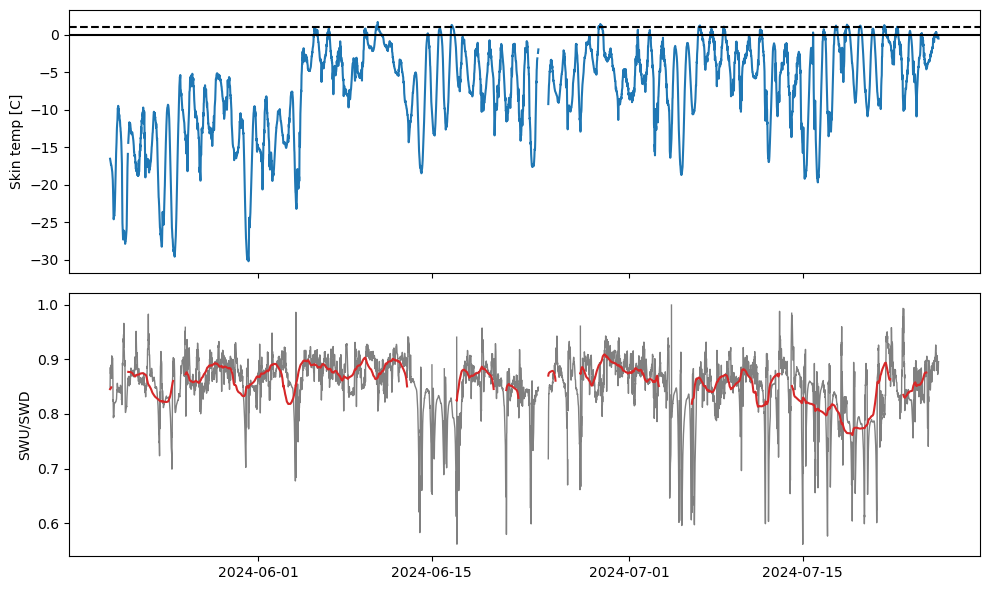

In [25]:

short_idx = np.where((asfs_data_summ['dates']>datetime.datetime(2024,5,20))&(asfs_data_summ['dates']<datetime.datetime(2024,8,1)))[0]
fig, axs = plt.subplots(2, figsize=(10,6), sharex=True)
# 'sr30_swd_Irr_Avg','sr30_swu_IrrC_Avg',



albedo = np.ma.masked_outside(asfs_data_summ['sr30_swu_IrrC_mean'][short_idx], -1000,1000)/np.ma.masked_outside(asfs_data_summ['sr30_swd_IrrC_mean'][short_idx], -1000,1000)
albedo = np.ma.masked_greater(albedo,1)
N = 4*24
albedo_run = np.ma.convolve(albedo, np.ones(N)/N, mode='valid')

axs[1].plot(asfs_data_summ['dates'][short_idx], albedo, c='gray', lw=1)
axs[1].plot(asfs_data_summ['dates'][short_idx][:-N+1], albedo_run, c='tab:red')

axs[1].set_ylabel('SWU/SWD')




axs[0].plot(asfs_data_summ['dates'][short_idx], asfs_data_summ['skin_temp_mean'][short_idx])
    
# axs[0].set_ylim(-10,10)
# axs[0].legend(loc='best')
axs[0].axhline(y=0, c='k')
axs[0].axhline(y=1, c='k', ls='--')

# axs[0].set_xlim(datetime.datetime(2024,5,15),datetime.datetime(2024,6,1))
# axs[0].set_xlim(st_date, en_date)
axs[0].set_ylabel('Skin temp [C]')
plt.tight_layout()
plt.show()

In [26]:
imb_sfc_temp = np.asarray(imb_sfc_temp)
imb_nr_sfc_temp = np.asarray(imb_nr_sfc_temp)
imb_abv_sfc_temp = np.asarray(imb_abv_sfc_temp)
imb_2abv_sfc_temp = np.asarray(imb_2abv_sfc_temp)

/tmp/ipykernel_3751741/62372892.py:1: UserWarning: Warning: converting a masked element to nan.
  imb_sfc_temp = np.asarray(imb_sfc_temp)
/tmp/ipykernel_3751741/62372892.py:2: UserWarning: Warning: converting a masked element to nan.
  imb_nr_sfc_temp = np.asarray(imb_nr_sfc_temp)
/tmp/ipykernel_3751741/62372892.py:3: UserWarning: Warning: converting a masked element to nan.
  imb_abv_sfc_temp = np.asarray(imb_abv_sfc_temp)
/tmp/ipykernel_3751741/62372892.py:4: UserWarning: Warning: converting a masked element to nan.
  imb_2abv_sfc_temp = np.asarray(imb_2abv_sfc_temp)


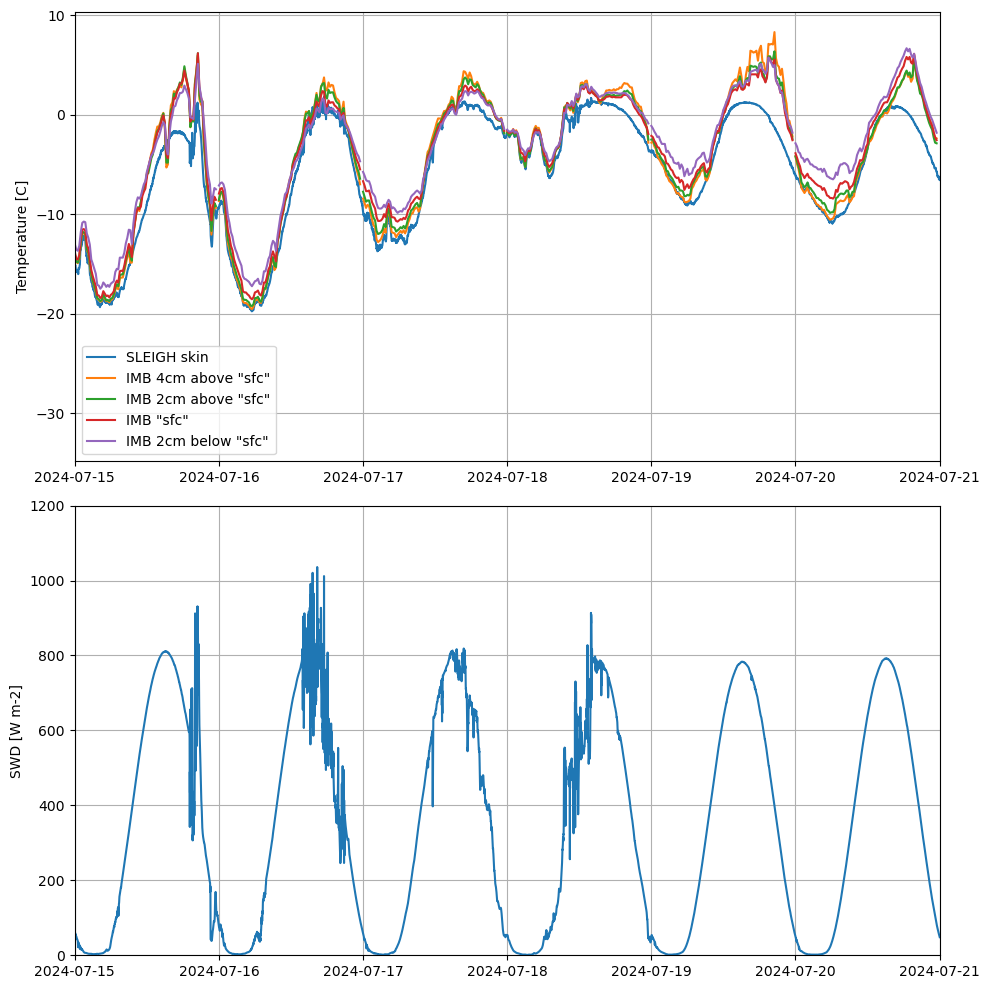

In [40]:
fig, axs = plt.subplots(2, figsize=(10,10))
short_idx = np.where((asfs_data['dates']>datetime.datetime(2024,5,20))&(asfs_data['dates']<datetime.datetime(2024,8,1)))[0]
axs[1].plot(asfs_data['dates'][short_idx], np.ma.masked_outside(asfs_data['sr30_swd_IrrC_Avg'][short_idx],0,9000))
axs[0].plot(asfs_data['dates'][short_idx], asfs_data['skin_temp_surface'][short_idx], label='SLEIGH skin')

axs[0].plot(imb_sfc_dates, imb_2abv_sfc_temp-273.15, label='IMB 4cm above "sfc"')
axs[0].plot(imb_sfc_dates, imb_abv_sfc_temp-273.15, label='IMB 2cm above "sfc"')
axs[0].plot(imb_sfc_dates, imb_sfc_temp-273.15, label='IMB "sfc"')
axs[0].plot(imb_sfc_dates, imb_nr_sfc_temp-273.15, label='IMB 2cm below "sfc"')


for ax in axs.ravel():
    ax.set_xlim(datetime.datetime(2024,7,15), datetime.datetime(2024,7, 21))
    ax.grid()

axs[0].set_ylabel('Temperature [C]')
axs[1].set_ylabel('SWD [W m-2]')
axs[1].set_ylim(0,1200)

axs[0].legend(loc='best')
plt.tight_layout()
plt.savefig('Raven_2024_SIMBA_sfc-abv-below_SLEIGH_temps_SWD_20240715-20240721.png')
plt.show()

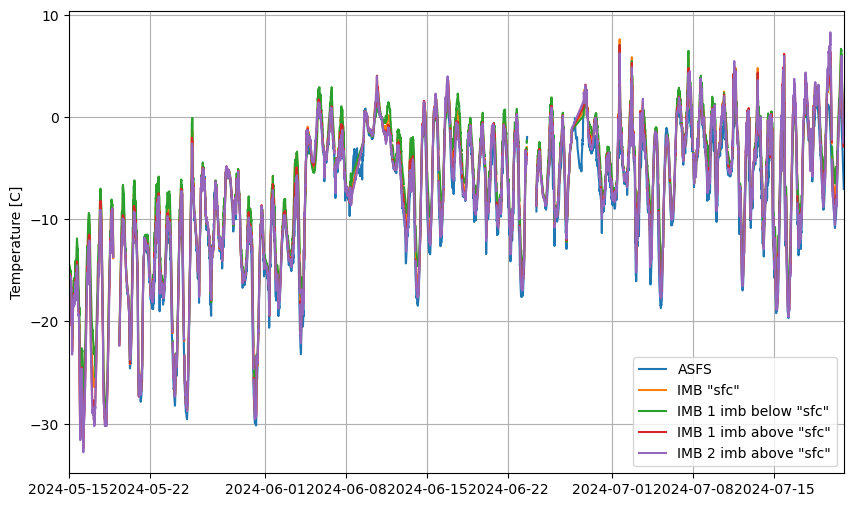

In [29]:
fig, ax = plt.subplots(1, figsize=(10,6))
plt.plot(asfs_data_summ['dates'][short_idx], asfs_data_summ['skin_temp_mean'][short_idx], label='ASFS')
plt.plot(imb_sfc_dates, imb_sfc_temp-273.15, label='IMB "sfc"')
plt.plot(imb_sfc_dates, imb_nr_sfc_temp-273.15, label='IMB 1 imb below "sfc"')
plt.plot(imb_sfc_dates, imb_abv_sfc_temp-273.15, label='IMB 1 imb above "sfc"')
plt.plot(imb_sfc_dates, imb_2abv_sfc_temp-273.15, label='IMB 2 imb above "sfc"')

plt.xlim(datetime.datetime(2024,5,15), datetime.datetime(2024,7, 21))
# plt.ylim(-20,5)
plt.grid()

plt.ylabel('Temperature [C]')
plt.legend(loc='best')
plt.show()

In [60]:
asfs_summ_idx = np.where((asfs_data_summ['dates']>datetime.datetime(2024,5,15))&(asfs_data_summ['dates']<datetime.datetime(2024,7,21)))[0]
imb_idx = np.where((season_data['dates']>datetime.datetime(2024,5,15))&(season_data['dates']<datetime.datetime(2024,7,21)))[0]

asfs_skin_summ = np.ma.masked_greater(asfs_data_summ['skin_temp_mean'][asfs_summ_idx],1)

swd_summ = np.ma.masked_outside(asfs_data_summ['sr30_swd_IrrC_mean'][asfs_summ_idx],-50,1000)
swn_summ = np.ma.masked_outside(asfs_data_summ['sr30_swd_IrrC_mean'][asfs_summ_idx], -1000,1000) - np.ma.masked_outside(asfs_data_summ['sr30_swu_IrrC_mean'][asfs_summ_idx], -1000,1000)

# albedo_summ = albedo_run[asfs_summ_idx]
abledo_raw = np.ma.masked_outside(asfs_data_summ['sr30_swu_IrrC_mean'][asfs_summ_idx], -1000,1000)/np.ma.masked_outside(asfs_data_summ['sr30_swd_IrrC_mean'][asfs_summ_idx], -1000,1000)
temp_diff = np.asarray(imb_abv_sfc_temp)-273.15 - asfs_skin_summ


/tmp/ipykernel_3532445/1500574327.py:11: UserWarning: Warning: converting a masked element to nan.
  temp_diff = np.asarray(imb_abv_sfc_temp)-273.15 - asfs_skin_summ


In [61]:
print(np.shape(imb_abv_sfc_temp), np.shape(imb_idx))

(6431,) (6431,)


(6431,)
(6431,)


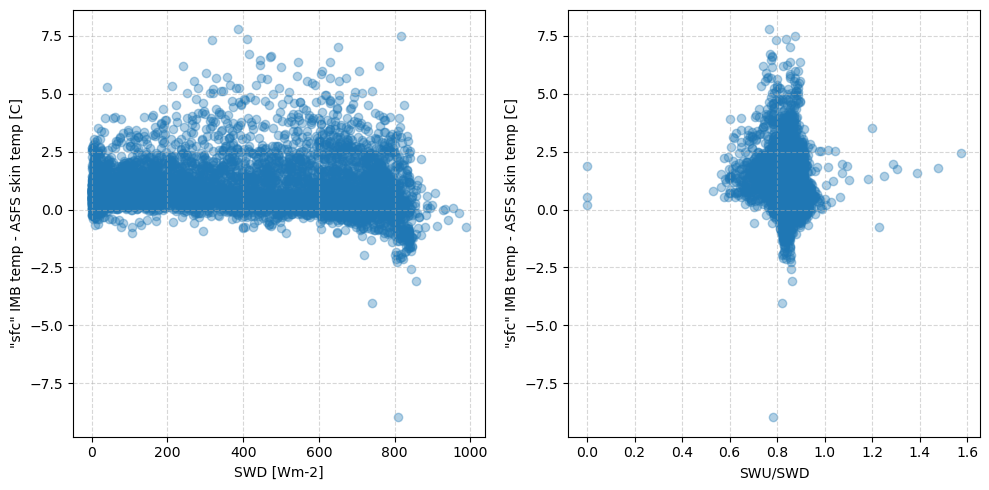

In [63]:
fig, axs = plt.subplots(1,2, figsize=(10,5))


for xvar, ax, label in zip([swd_summ,abledo_raw],axs.ravel(),['SWD [Wm-2]','SWU/SWD']):
    print(np.shape(swd_summ))
    ax.scatter(xvar, temp_diff, alpha=.35)
    ax.set_ylabel('"sfc" IMB temp - ASFS skin temp [C]')
    ax.set_xlabel(label)
    ax.grid(alpha=.5, ls='--')

plt.tight_layout()
plt.show()

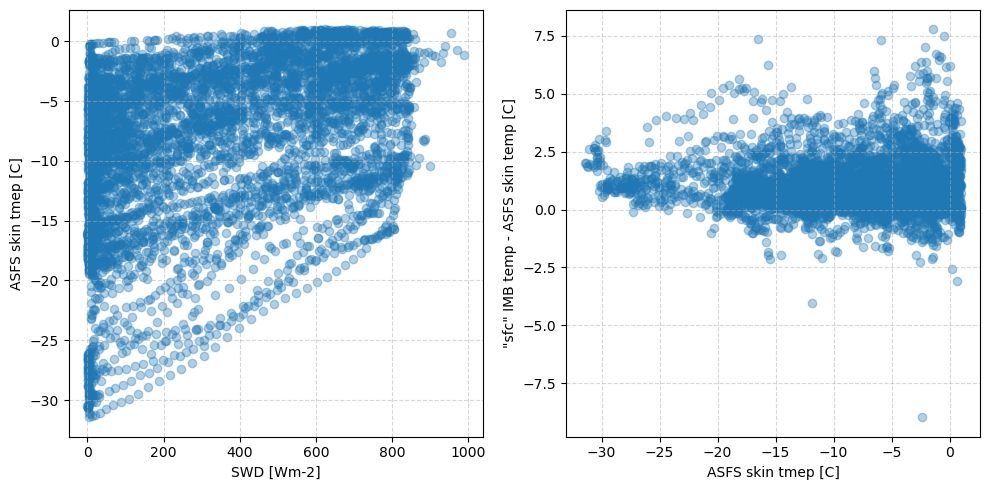

In [66]:
fig, axs = plt.subplots(1,2, figsize=(10,5))

axs[0].scatter(swd_summ, asfs_skin_summ, alpha=.35)
axs[0].set_ylabel('ASFS skin tmep [C]')
axs[0].set_xlabel('SWD [Wm-2]')

axs[1].scatter(asfs_skin_summ, temp_diff, alpha=.35)
axs[1].set_xlabel('ASFS skin tmep [C]')
axs[1].set_ylabel('"sfc" IMB temp - ASFS skin temp [C]')


for ax in axs.ravel():
    ax.grid(alpha=.5, ls='--')

plt.tight_layout()
plt.show()